In [56]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from datasets import Dataset, DatasetDict
from datasets import Value, ClassLabel, Features, Sequence
from collections import defaultdict
from huggingface_hub import login
from tokenization_helper import tokenize_text, tokenize_with_context

This notebook convert raw JSONs of PIE and MAGPIE dataset to HuggingFace Dataset format for NER task. 

In [57]:
PATH_PIE = '../data/raw/PIE_annotations_all_v2.json'
PATH_MAGPIE = '../data/raw/magpie-corpus.jsonl'

SEED = 42

## Read data

In [58]:
pie_df = pd.read_json(PATH_PIE)
magpie_df = pd.read_json(PATH_MAGPIE, lines=True)

In [59]:
pie_df.head()

,sense_label,offsets,idiom,PIE_label,sentence_number,context,context_untokenized,document_id
0,y,"[[0, 3], [4, 9]]",all along,y,3239,"[She was said to be callous , selfish , irresp...","[She was said to be callous, selfish, irrespon...",CH1
1,?,"[[118, 121], [225, 230]]",all along,n,1279,"[Dear Tim , David and Geoff, Microconcord, You...","[Dear Tim, David and Geoff, Microconcord, You ...",AP1
2,y,"[[26, 29], [30, 34], [39, 44]]",all over the place,y,65,[The way things were going I thought it was ti...,[The way things were going I thought it was ti...,A61
3,n,"[[26, 28], [29, 32]]",at sea,y,3220,"[Even in his early days , when I did an end-of...","[Even in his early days, when I did an end-of-...",CH1
4,n,"[[333, 335], [340, 343], [344, 346], [351, 354]]",at the end of the day,y,1343,[Matters are made easier for us in the United ...,[Matters are made easier for us in the United ...,A75


In [60]:
pie_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2239 entries, 0 to 2238
Data columns (total 8 columns):
 #   Column               Non-Null Count  Dtype 
---  ------               --------------  ----- 
 0   sense_label          2239 non-null   object
 1   offsets              2239 non-null   object
 2   idiom                2239 non-null   object
 3   PIE_label            2239 non-null   object
 4   sentence_number      2239 non-null   int64 
 5   context              2239 non-null   object
 6   context_untokenized  2239 non-null   object
 7   document_id          2239 non-null   object
dtypes: int64(1), object(7)
memory usage: 140.1+ KB


In [61]:
magpie_df.head()

,confidence,context,document_id,genre,id,idiom,judgment_count,label,label_distribution,non_standard_usage_explanations,offsets,sentence_no,split,variant_type
0,1.0,"[, , One can not come to terms with the past ,...",p39d1118,PMB,0,come to terms with,3,i,"{'?': 0.0, 'f': 0.0, 'i': 1.0, 'l': 0.0, 'o': ...",[],"[[12, 16], [17, 19], [20, 25], [26, 30]]",0,training,identical
1,1.0,[And there may be one or two other things we w...,J97,S meeting,1,call it a day,3,i,"{'?': 0.0, 'f': 0.0, 'i': 1.0, 'l': 0.0, 'o': ...",[],"[[9, 13], [14, 16], [19, 22]]",470,training,identical
2,1.0,"[It was the first thing I asked.’, Lindsey nod...",JXW,W fict prose,2,out of the blue,3,i,"{'?': 0.0, 'f': 0.0, 'i': 1.0, 'l': 0.0, 'o': ...",[],"[[77, 80], [81, 83], [88, 92]]",1202,training,identical
3,1.0,[When I took these two guitars into the studio...,C9M,W pop lore,3,full tilt,5,i,"{'?': 0.0, 'f': 0.0, 'i': 1.0, 'l': 0.0, 'o': ...",[],"[[234, 238], [239, 243]]",1117,training,identical
4,1.0,"[Now , generally speaking wi I I I 've act wha...",JT1,S lect soc science,4,on paper,3,l,"{'?': 0.0, 'f': 0.0, 'i': 0.0, 'l': 1.0, 'o': ...",[],"[[102, 104], [115, 120]]",291,training,insertion-other


In [62]:
magpie_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 56622 entries, 0 to 56621
Data columns (total 14 columns):
 #   Column                           Non-Null Count  Dtype  
---  ------                           --------------  -----  
 0   confidence                       56622 non-null  float64
 1   context                          56622 non-null  object 
 2   document_id                      56622 non-null  object 
 3   genre                            56622 non-null  object 
 4   id                               56622 non-null  int64  
 5   idiom                            56622 non-null  object 
 6   judgment_count                   56622 non-null  int64  
 7   label                            56622 non-null  object 
 8   label_distribution               56622 non-null  object 
 9   non_standard_usage_explanations  56622 non-null  object 
 10  offsets                          56622 non-null  object 
 11  sentence_no                      56622 non-null  int64  
 12  split             

## Prepare PIE data

Remove PIEs offsets from controversial objects. From docs:<br>
`PIE_label: label indicating whether this sentence contains the PIE in question ('y') or not ('n')`

For example 'They do this even though they may break the conventions from time to time .'
doesn't contain 'break even' idiom

In [63]:
pie_df['PIE_label'].value_counts()

PIE_label
n    1189
y    1050
Name: count, dtype: int64

In [64]:
pie_df.loc[pie_df['PIE_label'] == 'n', 'offsets'] = None 

Extract NERs

In [65]:
# take only 3-rd sentence with NER inside
# pie_df['context_pie_only'] = pd.DataFrame(pie_df['context'].to_list())[2]

# pie_df[['tokens', 'ner_tags']] = pie_df.apply(lambda x: tokenize_text(x.context_pie_only, x.offsets), 
#              axis=1, result_type='expand')

In [66]:
pie_df[['tokens', 'ner_tags']] = pie_df.apply(lambda x: tokenize_with_context(x.context, x.offsets), 
             axis=1, result_type='expand')

Select only relevant features for final view 

In [18]:
pie_df['is_pie'] = pie_df['PIE_label'] == 'y'

In [30]:
pie_df = pie_df[['idiom', 'is_pie', 'tokens', 'ner_tags']]

In [31]:
pie_df.head()

,idiom,is_pie,tokens,ner_tags
0,all along,True,"[She, was, said, to, be, callous, ,, selfish, ...","[O, O, O, O, O, O, O, O, O, O, O, O, O, O, O, ..."
1,all along,False,"[Dear, Tim, ,, David, and, Geoff, Microconcord...","[O, O, O, O, O, O, O, O, O, O, O, O, O, O, O, ..."
2,all over the place,True,"[The, way, things, were, going, I, thought, it...","[O, O, O, O, O, O, O, O, O, O, O, O, O, O, O, ..."
3,at sea,True,"[Even, in, his, early, days, ,, when, I, did, ...","[O, O, O, O, O, O, O, O, O, O, O, O, O, O, O, ..."
4,at the end of the day,True,"[Matters, are, made, easier, for, us, in, the,...","[O, O, O, O, O, O, O, O, O, O, O, O, O, O, O, ..."


## Prepare MAGPIE data

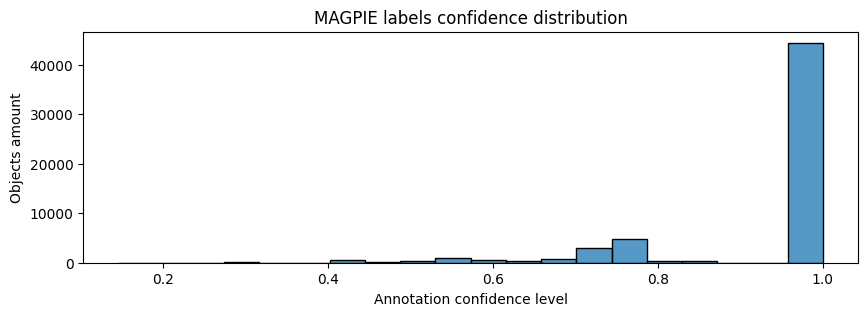

In [24]:
plt.figure(figsize=(10, 3))
plt.title('MAGPIE labels confidence distribution')
sns.histplot(magpie_df['confidence'], edgecolor='black', bins=20)
plt.xlabel('Annotation confidence level')
plt.ylabel('Objects amount')
plt.show()

Based on the analogy of the author of the corpus, we will use a threshold value of 75% confidence. 
In analogy with the PIE corpus, all examples with a value below the threshold will receive a False label.

In [25]:
magpie_df['is_pie'] = magpie_df['confidence'] > 0.75
magpie_df.loc[magpie_df['is_pie'] == False, 'offsets'] = None 

In [ ]:
# magpie_df['context_pie_only'] = pd.DataFrame(magpie_df['context'].to_list())[2]
# magpie_df[['tokens', 'ner_tags']] = magpie_df.apply(lambda x: tokenize_text(x.context_pie_only, x.offsets), 
#              axis=1, result_type='expand')

In [26]:
magpie_df[['tokens', 'ner_tags']] = magpie_df.apply(lambda x: tokenize_with_context(x.context, x.offsets), 
             axis=1, result_type='expand')

In [29]:
magpie_df = magpie_df[['idiom', 'is_pie', 'tokens', 'ner_tags']]

In [32]:
magpie_df.head()

,idiom,is_pie,tokens,ner_tags
0,come to terms with,True,"[One, can, not, come, to, terms, with, the, pa...","[O, O, O, B-PIE, I-PIE, I-PIE, I-PIE, O, O, O,..."
1,call it a day,True,"[And, there, may, be, one, or, two, other, thi...","[O, O, O, O, O, O, O, O, O, O, O, O, O, O, O, ..."
2,out of the blue,True,"[It, was, the, first, thing, I, asked.’, Linds...","[O, O, O, O, O, O, O, O, O, O, O, O, O, O, O, ..."
3,full tilt,True,"[When, I, took, these, two, guitars, into, the...","[O, O, O, O, O, O, O, O, O, O, O, O, O, O, O, ..."
4,on paper,True,"[Now, ,, generally, speaking, wi, I, I, I, 've...","[O, O, O, O, O, O, O, O, O, O, O, O, O, O, O, ..."


In [35]:
print(magpie_df["tokens"][1])
print(magpie_df["ner_tags"][1])

['And', 'there', 'may', 'be', 'one', 'or', 'two', 'other', 'things', 'we', 'work', 'through', 'over', 'this', 'meeting', 'and', 'the', 'next', 'meeting', '.', 'We', 'are', 'close', 'to', 'the', 'end', 'of', 'erm', 'You', 'should', 'be', 'lively', 'signing', 'this', 'document', '.', 'We', 'might', 'call', 'it', 'a', 'day', 'at', 'the', 'end', 'of', 'the', 'assignments', 'and', 'take', 'Jenny', "'s", 'away', 'to', 'recap', ',', 'erm', 'lets', 'get', 'to', 'the', 'end', 'of', 'the', 'assignments', 'first', ',', 'Q', 'P9', '.', 'Where', 'is', 'Q', 'P9', '?', 'papers', 'rustling', 'This', 'one', 'I', 'think', 'we', 'should', 'give', 'a', 'little', 'thought', ',', 'because', 'this', 'is', 'the', 'one', 'I', 'think', 'where', 'oh', 'yes', 'this', 'is', 'going', 'to', 'get', 'complicated', 'because', 'I', 'have', 'now', 'been', 'given', 'a', 'quiff', 'and', 'a', 'few', 'suggestion', 'forms', 'about', 'it', 'You', 'said', 'you', 'did', "n't", 'have', 'the', 'print', 'of', 'it', ',', 'is', 'that

## Convert DataFrames to HuggingFace Dataset

In [38]:
df = pd.concat([pie_df, magpie_df], ignore_index=True)

Remove duplicates

In [39]:
dupl_amount = df['tokens'].str.join(sep='').duplicated().sum()
print(f'Duplicates amount:{dupl_amount}')
print(f'Duplicates ratio {dupl_amount/len(df) :.3f}')


Duplicates amount:1248
Duplicates ratio 0.021


In [40]:
df = df.loc[~df['tokens'].str.join(sep='').duplicated(), :].reset_index(drop=True)

In [41]:
df.head()

,idiom,is_pie,tokens,ner_tags
0,all along,True,"[She, was, said, to, be, callous, ,, selfish, ...","[O, O, O, O, O, O, O, O, O, O, O, O, O, O, O, ..."
1,all along,False,"[Dear, Tim, ,, David, and, Geoff, Microconcord...","[O, O, O, O, O, O, O, O, O, O, O, O, O, O, O, ..."
2,all over the place,True,"[The, way, things, were, going, I, thought, it...","[O, O, O, O, O, O, O, O, O, O, O, O, O, O, O, ..."
3,at sea,True,"[Even, in, his, early, days, ,, when, I, did, ...","[O, O, O, O, O, O, O, O, O, O, O, O, O, O, O, ..."
4,at the end of the day,True,"[Matters, are, made, easier, for, us, in, the,...","[O, O, O, O, O, O, O, O, O, O, O, O, O, O, O, ..."


In [42]:
df.to_csv('../data/processed/final_data.csv')

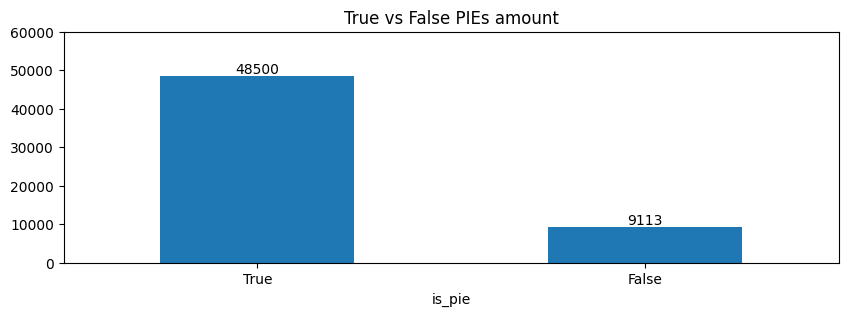

In [43]:
fig, ax = plt.subplots(figsize=(10, 3))
plt.title('True vs False PIEs amount')
df['is_pie'].value_counts().plot(kind='bar', ax=ax)
ax.bar_label(ax.containers[-1], label_type='edge')
plt.ylim([None, 60000])
plt.xticks(rotation=0)
plt.show()

Apply stratified split

In [44]:
train, valid_test = train_test_split(df, test_size=0.2, 
                                     stratify = df['is_pie'],
                                     shuffle=True, 
                                     random_state=SEED)

valid, test = train_test_split(valid_test, test_size=0.5, 
                                     stratify = valid_test['is_pie'],
                                     shuffle=True, 
                                     random_state=SEED)

In [45]:
len(train), len(valid), len(test)

(46090, 5761, 5762)

In [46]:
print(train['is_pie'].value_counts())
print(valid['is_pie'].value_counts())
print(test['is_pie'].value_counts())

is_pie
True     38800
False     7290
Name: count, dtype: int64
is_pie
True     4850
False     911
Name: count, dtype: int64
is_pie
True     4850
False     912
Name: count, dtype: int64


Define feature schema and create DatasetDict

In [47]:
features = Features({"idiom": Value("string"), 
                     "is_pie": Value("bool"),
                     "tokens": Sequence(Value('string')),
                     "ner_tags": Sequence(ClassLabel(num_classes=3, names=['O', 'B-PIE', 'I-PIE'])) })
                     

In [48]:
dataset_dict = DatasetDict()
dataset_dict['train'] = Dataset.from_pandas(train, features=features, preserve_index=False)
dataset_dict['validation'] = Dataset.from_pandas(valid, features=features, preserve_index=False)
dataset_dict['test'] = Dataset.from_pandas(test, features=features, preserve_index=False)

In [49]:
dataset_dict

DatasetDict({
    train: Dataset({
        features: ['idiom', 'is_pie', 'tokens', 'ner_tags'],
        num_rows: 46090
    })
    validation: Dataset({
        features: ['idiom', 'is_pie', 'tokens', 'ner_tags'],
        num_rows: 5761
    })
    test: Dataset({
        features: ['idiom', 'is_pie', 'tokens', 'ner_tags'],
        num_rows: 5762
    })
})

In [50]:
dataset_dict['train'].features

{'idiom': Value(dtype='string', id=None),
 'is_pie': Value(dtype='bool', id=None),
 'tokens': Sequence(feature=Value(dtype='string', id=None), length=-1, id=None),
 'ner_tags': Sequence(feature=ClassLabel(names=['O', 'B-PIE', 'I-PIE'], id=None), length=-1, id=None)}

Save locally and push to hub

In [51]:
dataset_dict.save_to_disk('../data/processed/pie_dataset')

Saving the dataset (0/1 shards):   0%|          | 0/46090 [00:00<?, ? examples/s]

Saving the dataset (0/1 shards):   0%|          | 0/5761 [00:00<?, ? examples/s]

Saving the dataset (0/1 shards):   0%|          | 0/5762 [00:00<?, ? examples/s]

In [ ]:
login()

In [53]:

dataset_dict.push_to_hub("Gooogr/pie_idioms")

Pushing split train to the Hub.


Pushing dataset shards to the dataset hub:   0%|          | 0/1 [00:00<?, ?it/s]

Creating parquet from Arrow format:   0%|          | 0/47 [00:00<?, ?ba/s]

Deleting unused files from dataset repository:   0%|          | 0/1 [00:00<?, ?it/s]

Pushing split validation to the Hub.


Pushing dataset shards to the dataset hub:   0%|          | 0/1 [00:00<?, ?it/s]

Creating parquet from Arrow format:   0%|          | 0/6 [00:00<?, ?ba/s]

Deleting unused files from dataset repository:   0%|          | 0/1 [00:00<?, ?it/s]

Pushing split test to the Hub.


Pushing dataset shards to the dataset hub:   0%|          | 0/1 [00:00<?, ?it/s]

Creating parquet from Arrow format:   0%|          | 0/6 [00:00<?, ?ba/s]

Deleting unused files from dataset repository:   0%|          | 0/1 [00:00<?, ?it/s]